### This notebook converts the reconstructed-level simulation to pickled .npy files for training a regression model.

The generation steps are outlined here: https://github.com/miguelignacio/inputdata
The regression notebook is simply called TowardsCodesign.ipynb located in this repo.
**Next Step: Save as HDF5, better interface for ML applications**

In [1]:
#%matplotlib notebook
import uproot as ur
import k3d
import numpy as np
import awkward as ak

from matplotlib import pyplot as plt, colors
plt.rcParams["figure.figsize"] = [10.00, 6.]
plt.rcParams["figure.autolayout"] = True

## Get file and TTree, print branches, convert to array

In [14]:
input_file = "rec_piplus_1k.root"
output_npy = "pionplus_1k"

e_events = ur.open("%s:events"%(input_file)) #1k 20GeV electrons march3
e_events["HcalEndcapPHitsReco.energy"].array(library="pd") #pandas gives a nice quick view of the data

entry  subentry
0      0           8.239746e-03
       1           1.125900e+15
       2           1.125900e+15
       3           2.508545e-02
       4           1.125900e+15
                       ...     
999    549         1.125900e+15
       550         1.125900e+15
       551         1.125900e+15
       552         1.125900e+15
       553         1.125900e+15
Length: 267816, dtype: float32

In [3]:
#def get_vector(events,varname='HcalEndcapHits',energy='energy'):
def get_vector(events,varname='HcalEndcapHitsP',energy='energy'):
    E = events["%s.%s"%(varname,energy)].array(library='np')
    x = events["%s.position.x"%varname].array(library='np')
    y = events["%s.position.y"%varname].array(library='np')
    z = events["%s.position.z"%varname].array(library='np')
    #theta = events["%s.polar.theta"%varname].array(library='np')
    #phi = events["%s.polar.phi"%varname].array(library='np')

    return E,x, y, z, theta, phi

def get_truth(gen_events,varname="MCParticles"):
    pdgID = gen_events["%s.%s"%(varname,'PDG')].array(library='np')
    status = gen_events["%s.%s"%(varname,'simulatorStatus')].array(library='np')
    genStatus = gen_events["%s.%s"%(varname,'generatorStatus')].array(library='np')
    pex = gen_events["%s.%s"%(varname,'momentum.x')].array(library='np')
    pey = gen_events["%s.%s"%(varname,'momentum.y')].array(library='np')
    pez = gen_events["%s.%s"%(varname,'momentum.z')].array(library='np')
    mass = gen_events["%s.%s"%(varname,'mass')].array(library='np')
    
    #genStatus = gen_events['mcparticles.genStatus'].array(library='np')
    #pex = gen_events['MCParticles.psx'].array(library='np')
    #pey = gen_events['MCParticles.psy'].array(library='np')
    #pez = gen_events['MCParticles.psz'].array(library='np')
    #mass = gen_events['MCParticles.mass'].array(library='np')
    return pdgID,status, genStatus,pex,pey,pez,mass

In [4]:
E = {}
x = {}
y = {}
z  = {}
theta={}
phi = {}

## Get data

# get hits

In [5]:
for i in ['HcalEndcapP','EcalEndcapP']:#,'TrackerEndcap','VertexEndcap']:
    tag = 'e_' + i
    E[tag], x[tag], y[tag],z[tag],theta[tag],phi[tag] = get_vector(e_events,varname="%sHitsReco"%i)

## get MC

In [6]:
def get_GeneratedValues(events):
    mc = {} 
    mc['pdgID'], mc['status'], mc['genStatus'], mc['pex'],mc['pey'], mc['pez'], mc['mass']= get_truth(events)
    for i in range(len(mc['pdgID'][0])):
        if(mc['genStatus'][0][i] !=1): continue
        px = mc['pex'][0][i]
        py =  mc['pey'][0][i]
        pz = mc['pez'][0][i]
        pt =  np.sqrt(px*px + py*py)
        p = np.sqrt(px*px+py*py+pz*pz)
        theta = np.arccos(pz/p)*180/np.pi
        print('MC particle ID ', mc['pdgID'][0][i],  'genStatus ', mc['genStatus'][0][i],
               ' px = %2.2f, py=%2.2f, pz=%2.2f'%(mc['pex'][0][i],mc['pey'][0][i],mc['pez'][0][i]))
        print('p = %2.2f , theta =%2.2f'%(p, theta))
    return p, theta

truth = {}
truth['e_p'], truth['e_theta'] = get_GeneratedValues(e_events)

MC particle ID  211 genStatus  1  px = 0.00, py=-3.49, pz=19.70
p = 20.01 , theta =10.04


## Get clusters

In [7]:
#for i in ['HcalBarrelClusters','HcalHadronEndcapClusters','EcalBarrelClusters','EcalEndcapClusters']:
#    E[i], x[i], y[i],z[i] = get_vector("%s"%i,energy='energy')

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

In [9]:
print(x.keys())

dict_keys(['e_HcalEndcapP', 'e_EcalEndcapP'])


## Plot 2D transverse view for hits in endcap

/tmp/ipykernel_24783/2345968297.py:75: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cell_x = x[key][ievt][mask]
/tmp/ipykernel_24783/2345968297.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cell_y = y[key][ievt][mask]
/tmp/ipykernel_24783/2345968297.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cell_

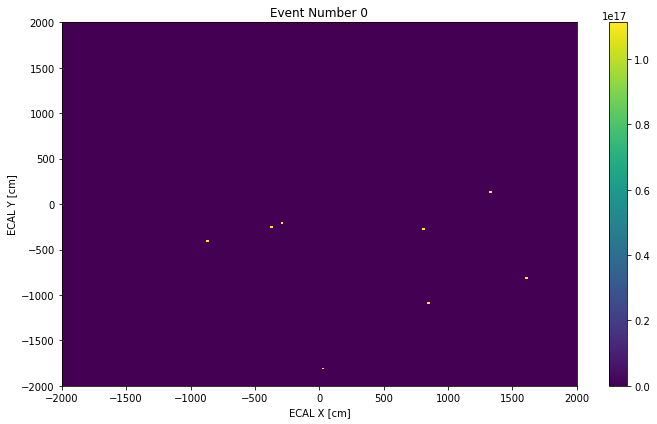

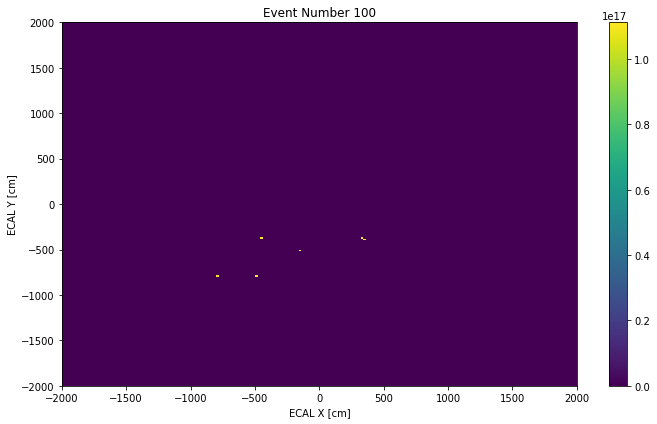

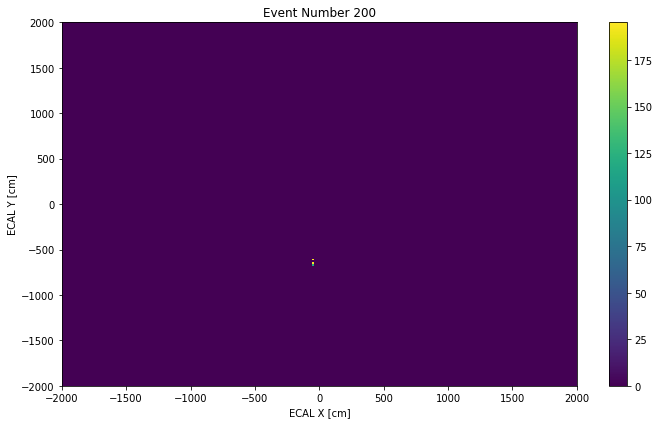

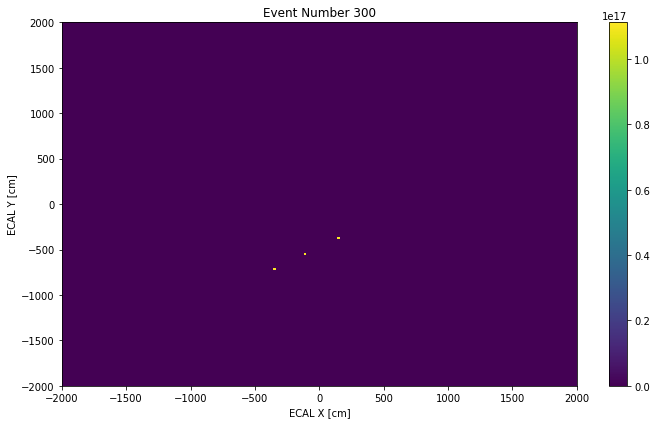

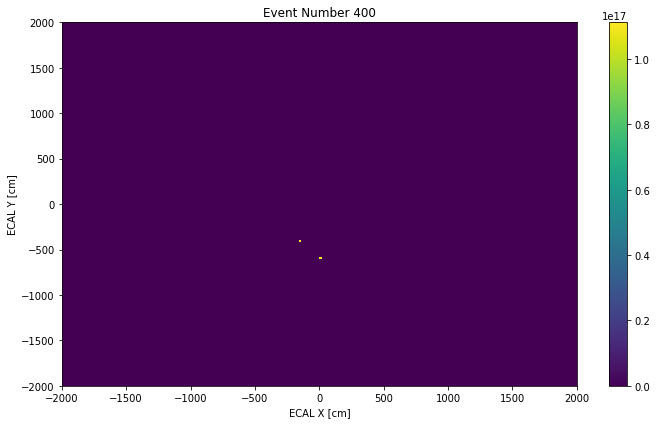

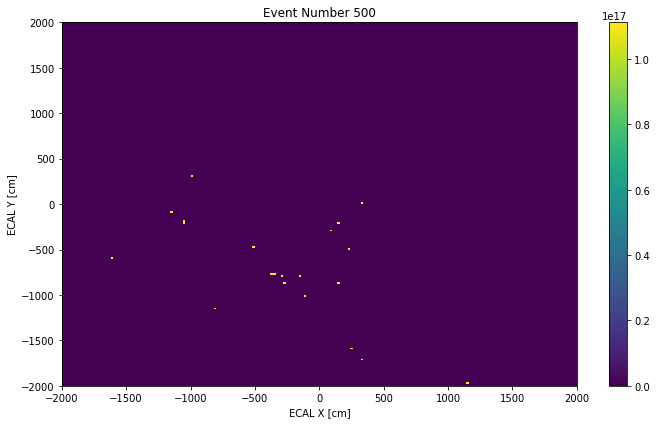

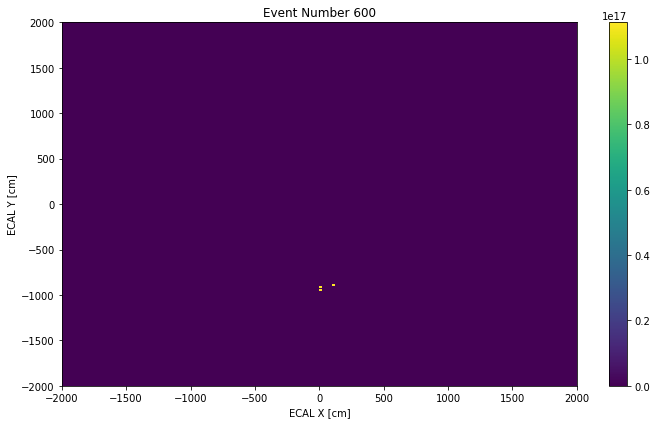

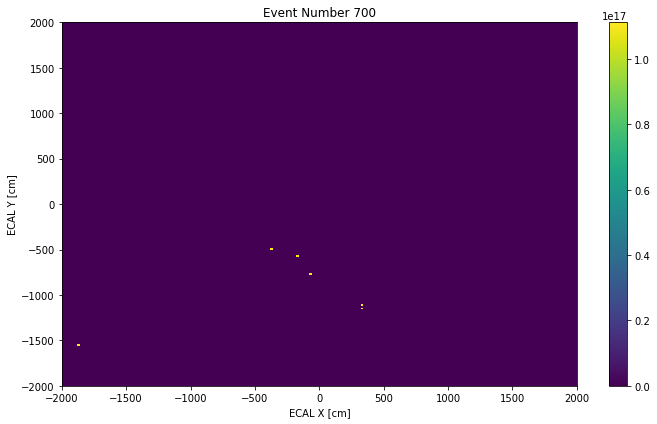

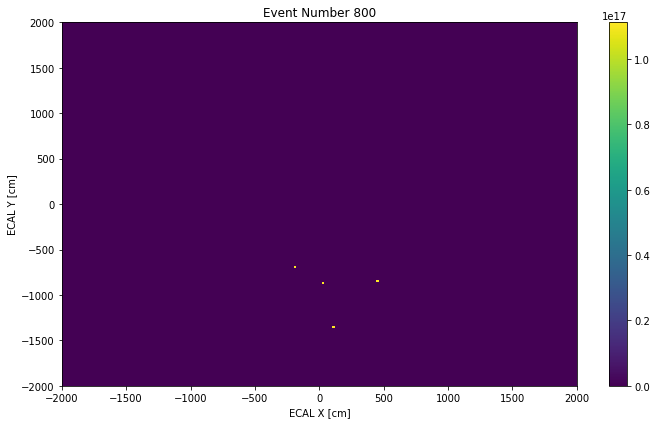

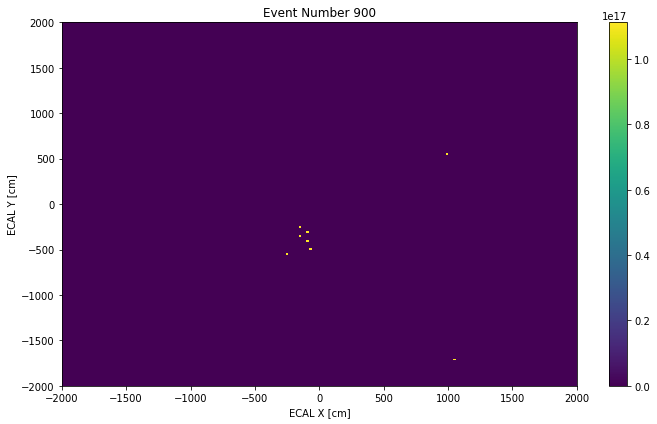

In [15]:
#loop over events
data = []

nevents = 1000
for ievt in range(0,nevents): #can the range be determined from the root file?
    for part_type in ['e']:#pi0 previously. See 'Get Hits' section
        ECAL = []
        key = '%s_EcalEndcapP'%(part_type)
        
        
        mask = (E[key][ievt]>0.005)
        #mask = [(E[key][ievt]>0.001) & (E[key][ievt]<10000)]
        #mask = [(E[key][ievt]<10)]
        #print(E)
   
        ECAL_x = x[key][ievt][mask]
        ECAL_y = y[key][ievt][mask]
        ECAL_E = E[key][ievt][mask]*1000.0 #(MeV)
        
        #print('NUmber of CELLS ', len(ECAL_E))
    
        #print(cell_x)
        #print(cell_E)
        
        N = 10
        if (ievt%(nevents/N)==0): #do for every N portion of the dataset
            fig, ax = plt.subplots()
            c = ax.hist2d(ECAL_x,ECAL_y, weights=ECAL_E,label=part_type + ' evt #%i'%(ievt), 
                         bins=[200,200],range=([[-2000, 2000], [-2000,2000]]))
            fig.colorbar(c[3], ax=ax)         
            ax.set_title("Event Number %i"%(ievt))
            ax.set_xlabel("ECAL X [cm]")
            ax.set_ylabel("ECAL Y [cm]")
        
        suma_ECAL = np.sum(E[key][ievt])
        #print('Event Number %i'%(ievt) , ' Suma ECAL =%2.2f GeV'%suma_ECAL)
        
        #### HCAL 
        
        #ECAL.append(list(cell_E))
        
        key = '%s_HcalEndcapP'%(part_type)

        #print('######################   Entering HCAL   ##########################')
        
        event_array = []
        for length_1 in range(100,500,20): #20 iterations
            for length_2 in range(100,500,20): #20 iterations (20x20=400 images). Changes z-position of HCal boundary for now
                Image = {}
                Image['ECAL_E'] = ECAL_E
                Image['ECAL_x'] = ECAL_x
                Image['ECAL_y'] = ECAL_y
                Image['HCAL1_E'] = []
                Image['HCAL2_E'] = []
                Image['HCAL3_E'] = []
                Image['HCAL1_x'] = []
                Image['HCAL2_x'] = []
                Image['HCAL3_x'] = []
                Image['HCAL1_y'] = []
                Image['HCAL2_y'] = []
                Image['HCAL3_y'] = []
                Image['boundary'] = (length_1, length_2)
                if(length_1+length_2>999): continue
                #fig,ax  = plt.subplots(1,4,figsize=(20,4),sharex=True, sharey=True)
    
                #print('Length 1= ', length_1,' legnth 2' , length_2)
                z_offset = 3800 #[mm]
                z_max = z_offset + 1200 #HCAL ~ 1.2m
                
                for iz, zbins in enumerate([(z_offset,z_offset+length_1),
                    (z_offset+length_1, z_offset+length_1+length_2),(z_offset+length_1+length_2,z_max)]):
                    #print('############')
                    mask = [(z[key][ievt]>zbins[0]) & (z[key][ievt]<zbins[1]) & (E[key][ievt]>0.0)]
                    if(np.sum(mask)<1): continue
                    cell_x = x[key][ievt][mask]
                    cell_y = y[key][ievt][mask]
                    cell_E = E[key][ievt][mask] *1000.0 # MEV
                    #print(cell_E)
                    #c = ax[iz+1].hist2d(cell_x,cell_y, weights=cell_E,label=part_type + ' evt #%i'%(ievt), 
                    #    bins=[40,40],range=([[-2000, 2000], [-2000,2000]]))
                    #fig.colorbar(c[3], ax=ax[iz+1])       
                    Image['HCAL%i_E'%(iz+1)].append(cell_E)
                    #print(iz," ,",cell_E)
                    Image['HCAL%i_x'%(iz+1)].append(cell_x)
                    Image['HCAL%i_y'%(iz+1)].append(cell_y)

                    #ax[iz+1].set_title('%i, %i'%(zbins[0],zbins[1]))
                    #HCAL['%i_x'%(iz+1)].append(list(cell_x))
                    #HCAL['%i_y'%(iz+1)].append(list(cell_y))

        #HCAL_tot = [HCAL['1'],HCAL['2'],HCAL['3'],(3200,3400)]  
        #print([HCAL,(length_1,length_2)])
                event_array.append(Image)
        
        data.append(event_array)
        ##END OF EVENT
        #ax[0].set_title('ECAL \n %s event'%(part_type))
        #for iz in range(3):
        #    ax[iz+1].set_title('HCAL %i \n %s event, %2.0f GeV'%(iz,part_type,truth[part_type+'_p']))

        #ax[0].legend()
        #for a in ax:
        #    a.set_xticklabels([])
        #    a.set_yticklabels([])
        #plt.subplots_adjust(wspace=0, hspace=0.5)
#TOTAL = []
mc_truth = {}
mc_truth['true_energy']=truth['e_p']
mc_truth['true_angle']=truth['e_theta']

with open("%s.npy"%(output_npy), 'wb') as f:
    np.save(f, mc_truth)
    np.save(f, data)

#print(data[ievt])

#print('Primera entry')
#print(data[0][1])
#print('Second entry')

#print(data[0][2])
#print('Thriy')

#print(data[0][3])

#print ('HCAL 1', HCAL['1'])
#print ('HCAL 2 ', HCAL['2'])
#print ('HCAL 3 ', HCAL['3'])

In [11]:
with open('%s.npy'%(output_npy), 'rb') as f:
    header = np.load(f,allow_pickle=True)
    print(header)
    print(type(header)) #figure this out (google)
    data = np.load(f,allow_pickle=True)
    print(data)
    ievt = 99  #could loop
    print('number of images in event', len(data[ievt]))
    ## Here we loop over all "images", which are created by integrating HCAL sampling layers defing 3 sectors defined 
    ## by two z position that define boundary. Note for all images ECAL is the same (no longitudinal separation in ECAL)
    for im in range(len(data[ievt])):
        print('#  IMAGE NUMBER %i############\n\n\n'%im)
        print(data[ievt][im]) #This is a dictionary
        print(data[ievt][im].keys())
        #print('HCAL1 x [mm] \n', data[ievt][im]['HCAL1_x']) ##This is x of HCAL#1 image im
        #print('HCAL1 y [mm]\n', data[ievt][im]['HCAL1_y']) ##This is y of HCAL#1 image im
        print('HCAL1 E [GeV]\n', data[ievt][im]['HCAL1_E']) ## this is E of HCAL#1 image im
        #print('HCAL2 x [mm]\n', data[ievt][im]['HCAL2_x']) ##This is x of HCAL#2 image im
        #print('HCAL2 y [mm]\n', data[ievt][im]['HCAL2_y']) ##This is y of HCAL#2 image im
        print('HCAL2 E [mm]\n', data[ievt][im]['HCAL2_E']) ## this is E of HCAL#2 image im
        #print('HCAL3 x [mm]\n',data[ievt][im]['HCAL3_x']) ##This is x of HCAL#3 image im
        #print('HCAL3 y [mm]\n',data[ievt][im]['HCAL3_y']) ##This is y of HCAL#3 image im
        print('HCAL3 E [mm]\n',data[ievt][im]['HCAL3_E']) ## this is E of HCAL#3 image im
        #print('ECAL x [mm]\n',data[ievt][im]['ECAL_E']) ## this is E of ECAL image im
        #print('ECAL y [mm]\n',data[ievt][im]['ECAL_x']) ## this is x of ECAL image im
        print('ECAL E [mm]\n',data[ievt][im]['ECAL_y']) ## this is x of ECAL image im
        #print('Boundaries\n',data[ievt][im]['boundary'])  ## This are the boundaries (z positions of long layers) used to created image


{'true_energy': 20.007061, 'true_angle': 10.041165259220588}
<class 'numpy.ndarray'>
[[{'ECAL_E': array([2.1983511e+01, 1.1125493e+17, 1.5126103e+01, 5.4340591e+00,
         7.0986538e+00, 7.2349579e+01, 1.9521600e+02, 1.5372176e+02,
         1.6146573e+02, 2.7260761e+01, 6.4955401e+00, 1.7502373e+01,
         9.9272594e+00, 3.2670696e+01, 1.8748407e+02, 3.7881603e+01,
         1.9521600e+02, 5.4762769e+00, 6.9358130e+00, 6.2301693e+00,
         1.9521600e+02, 3.7085491e+01, 2.5143829e+01, 1.9521600e+02,
         3.8985302e+01, 1.9521600e+02, 8.3621788e+01, 1.9854519e+01,
         8.1963224e+00, 1.6374550e+01, 1.7007820e+01, 4.3659439e+01,
         9.3699821e+01, 2.1404524e+01, 5.5727749e+00, 1.9521600e+02,
         5.2440777e+01, 7.8579742e+01, 1.9521600e+02, 9.5472975e+00,
         8.6721794e+01, 1.9287592e+01, 2.2701220e+01, 1.3485634e+01,
         1.9854519e+01, 5.6813354e+00, 1.5789529e+01, 1.6519297e+01,
         5.0661592e+00, 1.1236017e+01, 7.8042979e+00, 2.1235651e+01,
       

{'ECAL_E': array([1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 1.9521600e+02,
       1.1323469e+02, 1.3576100e+01, 1.9521600e+02, 1.9521600e+02,
       1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 5.1005367e+01,
       1.3085165e+02, 5.2151283e+01, 1.9521600e+02, 2.6573212e+01,
       8.0696678e+00, 1.9521600e+02, 2.5276516e+01, 5.3158485e+01,
       2.1386429e+01, 1.4655675e+01, 9.1673355e+00, 9.3784256e+00,
       7.2192769e+00, 1.1700415e+01, 7.1951523e+00, 1.1278235e+01,
       3.3659805e+01, 2.9124384e+01, 6.2542946e+01, 6.0190797e+00,
       1.0391657e+01, 1.3521820e+01, 2.3961727e+01, 1.2074346e+01,
       9.2276478e+00, 8.8054667e+00, 2.7296949e+01, 6.9237509e+00,
       1.2997111e+01, 1.0090100e+01, 2.1700048e+01, 1.5083886e+01,
       3.1211161e+01, 1.9860550e+01, 9.6257019e+00, 1.1125493e+17,
       1.1125493e+17, 6.2621349e+01, 1.0391657e+01, 6.1596050e+01,
       5.3858097e+01, 5.3291172e+01, 4.3086475e+01, 1.2966955e+01,
       1.9179031e+01, 6.5920382e+00, 1.7442062e+01,

{'ECAL_E': array([1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 1.9521600e+02,
       1.1323469e+02, 1.3576100e+01, 1.9521600e+02, 1.9521600e+02,
       1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 5.1005367e+01,
       1.3085165e+02, 5.2151283e+01, 1.9521600e+02, 2.6573212e+01,
       8.0696678e+00, 1.9521600e+02, 2.5276516e+01, 5.3158485e+01,
       2.1386429e+01, 1.4655675e+01, 9.1673355e+00, 9.3784256e+00,
       7.2192769e+00, 1.1700415e+01, 7.1951523e+00, 1.1278235e+01,
       3.3659805e+01, 2.9124384e+01, 6.2542946e+01, 6.0190797e+00,
       1.0391657e+01, 1.3521820e+01, 2.3961727e+01, 1.2074346e+01,
       9.2276478e+00, 8.8054667e+00, 2.7296949e+01, 6.9237509e+00,
       1.2997111e+01, 1.0090100e+01, 2.1700048e+01, 1.5083886e+01,
       3.1211161e+01, 1.9860550e+01, 9.6257019e+00, 1.1125493e+17,
       1.1125493e+17, 6.2621349e+01, 1.0391657e+01, 6.1596050e+01,
       5.3858097e+01, 5.3291172e+01, 4.3086475e+01, 1.2966955e+01,
       1.9179031e+01, 6.5920382e+00, 1.7442062e+01,

{'ECAL_E': array([1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 1.9521600e+02,
       1.1323469e+02, 1.3576100e+01, 1.9521600e+02, 1.9521600e+02,
       1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 5.1005367e+01,
       1.3085165e+02, 5.2151283e+01, 1.9521600e+02, 2.6573212e+01,
       8.0696678e+00, 1.9521600e+02, 2.5276516e+01, 5.3158485e+01,
       2.1386429e+01, 1.4655675e+01, 9.1673355e+00, 9.3784256e+00,
       7.2192769e+00, 1.1700415e+01, 7.1951523e+00, 1.1278235e+01,
       3.3659805e+01, 2.9124384e+01, 6.2542946e+01, 6.0190797e+00,
       1.0391657e+01, 1.3521820e+01, 2.3961727e+01, 1.2074346e+01,
       9.2276478e+00, 8.8054667e+00, 2.7296949e+01, 6.9237509e+00,
       1.2997111e+01, 1.0090100e+01, 2.1700048e+01, 1.5083886e+01,
       3.1211161e+01, 1.9860550e+01, 9.6257019e+00, 1.1125493e+17,
       1.1125493e+17, 6.2621349e+01, 1.0391657e+01, 6.1596050e+01,
       5.3858097e+01, 5.3291172e+01, 4.3086475e+01, 1.2966955e+01,
       1.9179031e+01, 6.5920382e+00, 1.7442062e+01,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'ECAL_E': array([1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 1.9521600e+02,
       1.1323469e+02, 1.3576100e+01, 1.9521600e+02, 1.9521600e+02,
       1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 5.1005367e+01,
       1.3085165e+02, 5.2151283e+01, 1.9521600e+02, 2.6573212e+01,
       8.0696678e+00, 1.9521600e+02, 2.5276516e+01, 5.3158485e+01,
       2.1386429e+01, 1.4655675e+01, 9.1673355e+00, 9.3784256e+00,
       7.2192769e+00, 1.1700415e+01, 7.1951523e+00, 1.1278235e+01,
       3.3659805e+01, 2.9124384e+01, 6.2542946e+01, 6.0190797e+00,
       1.0391657e+01, 1.3521820e+01, 2.3961727e+01, 1.2074346e+01,
       9.2276478e+00, 8.8054667e+00, 2.7296949e+01, 6.9237509e+00,
       1.2997111e+01, 1.0090100e+01, 2.1700048e+01, 1.5083886e+01,
       3.1211161e+01, 1.9860550e+01, 9.6257019e+00, 1.1125493e+17,
       1.1125493e+17, 6.2621349e+01, 1.0391657e+01, 6.1596050e+01,
       5.3858097e+01, 5.3291172e+01, 4.3086475e+01, 1.2966955e+01,
       1.9179031e+01, 6.5920382e+00, 1.7442062e+01,

{'ECAL_E': array([1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 1.9521600e+02,
       1.1323469e+02, 1.3576100e+01, 1.9521600e+02, 1.9521600e+02,
       1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 5.1005367e+01,
       1.3085165e+02, 5.2151283e+01, 1.9521600e+02, 2.6573212e+01,
       8.0696678e+00, 1.9521600e+02, 2.5276516e+01, 5.3158485e+01,
       2.1386429e+01, 1.4655675e+01, 9.1673355e+00, 9.3784256e+00,
       7.2192769e+00, 1.1700415e+01, 7.1951523e+00, 1.1278235e+01,
       3.3659805e+01, 2.9124384e+01, 6.2542946e+01, 6.0190797e+00,
       1.0391657e+01, 1.3521820e+01, 2.3961727e+01, 1.2074346e+01,
       9.2276478e+00, 8.8054667e+00, 2.7296949e+01, 6.9237509e+00,
       1.2997111e+01, 1.0090100e+01, 2.1700048e+01, 1.5083886e+01,
       3.1211161e+01, 1.9860550e+01, 9.6257019e+00, 1.1125493e+17,
       1.1125493e+17, 6.2621349e+01, 1.0391657e+01, 6.1596050e+01,
       5.3858097e+01, 5.3291172e+01, 4.3086475e+01, 1.2966955e+01,
       1.9179031e+01, 6.5920382e+00, 1.7442062e+01,

{'ECAL_E': array([1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 1.9521600e+02,
       1.1323469e+02, 1.3576100e+01, 1.9521600e+02, 1.9521600e+02,
       1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 5.1005367e+01,
       1.3085165e+02, 5.2151283e+01, 1.9521600e+02, 2.6573212e+01,
       8.0696678e+00, 1.9521600e+02, 2.5276516e+01, 5.3158485e+01,
       2.1386429e+01, 1.4655675e+01, 9.1673355e+00, 9.3784256e+00,
       7.2192769e+00, 1.1700415e+01, 7.1951523e+00, 1.1278235e+01,
       3.3659805e+01, 2.9124384e+01, 6.2542946e+01, 6.0190797e+00,
       1.0391657e+01, 1.3521820e+01, 2.3961727e+01, 1.2074346e+01,
       9.2276478e+00, 8.8054667e+00, 2.7296949e+01, 6.9237509e+00,
       1.2997111e+01, 1.0090100e+01, 2.1700048e+01, 1.5083886e+01,
       3.1211161e+01, 1.9860550e+01, 9.6257019e+00, 1.1125493e+17,
       1.1125493e+17, 6.2621349e+01, 1.0391657e+01, 6.1596050e+01,
       5.3858097e+01, 5.3291172e+01, 4.3086475e+01, 1.2966955e+01,
       1.9179031e+01, 6.5920382e+00, 1.7442062e+01,

{'ECAL_E': array([1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 1.9521600e+02,
       1.1323469e+02, 1.3576100e+01, 1.9521600e+02, 1.9521600e+02,
       1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 5.1005367e+01,
       1.3085165e+02, 5.2151283e+01, 1.9521600e+02, 2.6573212e+01,
       8.0696678e+00, 1.9521600e+02, 2.5276516e+01, 5.3158485e+01,
       2.1386429e+01, 1.4655675e+01, 9.1673355e+00, 9.3784256e+00,
       7.2192769e+00, 1.1700415e+01, 7.1951523e+00, 1.1278235e+01,
       3.3659805e+01, 2.9124384e+01, 6.2542946e+01, 6.0190797e+00,
       1.0391657e+01, 1.3521820e+01, 2.3961727e+01, 1.2074346e+01,
       9.2276478e+00, 8.8054667e+00, 2.7296949e+01, 6.9237509e+00,
       1.2997111e+01, 1.0090100e+01, 2.1700048e+01, 1.5083886e+01,
       3.1211161e+01, 1.9860550e+01, 9.6257019e+00, 1.1125493e+17,
       1.1125493e+17, 6.2621349e+01, 1.0391657e+01, 6.1596050e+01,
       5.3858097e+01, 5.3291172e+01, 4.3086475e+01, 1.2966955e+01,
       1.9179031e+01, 6.5920382e+00, 1.7442062e+01,

{'ECAL_E': array([1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 1.9521600e+02,
       1.1323469e+02, 1.3576100e+01, 1.9521600e+02, 1.9521600e+02,
       1.9521600e+02, 1.9521600e+02, 1.9521600e+02, 5.1005367e+01,
       1.3085165e+02, 5.2151283e+01, 1.9521600e+02, 2.6573212e+01,
       8.0696678e+00, 1.9521600e+02, 2.5276516e+01, 5.3158485e+01,
       2.1386429e+01, 1.4655675e+01, 9.1673355e+00, 9.3784256e+00,
       7.2192769e+00, 1.1700415e+01, 7.1951523e+00, 1.1278235e+01,
       3.3659805e+01, 2.9124384e+01, 6.2542946e+01, 6.0190797e+00,
       1.0391657e+01, 1.3521820e+01, 2.3961727e+01, 1.2074346e+01,
       9.2276478e+00, 8.8054667e+00, 2.7296949e+01, 6.9237509e+00,
       1.2997111e+01, 1.0090100e+01, 2.1700048e+01, 1.5083886e+01,
       3.1211161e+01, 1.9860550e+01, 9.6257019e+00, 1.1125493e+17,
       1.1125493e+17, 6.2621349e+01, 1.0391657e+01, 6.1596050e+01,
       5.3858097e+01, 5.3291172e+01, 4.3086475e+01, 1.2966955e+01,
       1.9179031e+01, 6.5920382e+00, 1.7442062e+01,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
#sf_ECAL = 0.253
#sf_HCAL = 0.025
    #print('Energy = %2.3f'%(suma_ECAL/sf_ECAL+suma_HCAL/sf_HCAL))
    ##suma_HCAL = np.sum(E[key][ievt])
    #print(suma_HCAL/sf_HCAL)

In [13]:
header=np.load('%s.npy'%(output_npy),allow_pickle=True)
print(header.item().get('true_energy'))

20.007061
